In [1]:
import os
import shutil
from shutil import copyfile
import random
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_dir = "./data/PetImages/"

train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

# 训练集
train_dogs = os.path.join(base_dir, 'training/dogs')
train_cats = os.path.join(base_dir, 'training/cats')

# 测试集
test_dogs = os.path.join(base_dir, 'testing/dogs')
test_cats = os.path.join(base_dir, 'testing/cats')

In [3]:
model = tf.keras.models.Sequential([
    # 如果训练慢，可以数据设置的更小一些
    # 得到filter32个特征图，卷积核3*3，默认激活层直接加relu，input_data输入大小
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # 池化层一般都是2*2，基本不改
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # 为全连接层做准备
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    # 二分类digmoid就够了，输出0-1之间的概率值
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [4]:
model.summary()
# 62 = (64 - 3) / 1 + 1, 32是输出个数， 896=3*3卷积核*3通道*32个卷积核+32即b值
# 池化层没权重参数，h，w变一半，个数不变
# 全连接层参数大，更容易过拟合

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy']
            )

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir, # 文件夹路径
    target_size=(64, 64), # 指定resize层的大小
    batch_size=20,
    # 如果one_hot就是categorical，二分类用binary就可以
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, # 文件夹路径
    target_size=(64, 64), # 指定resize层的大小
    batch_size=20,
    # 如果one_hot就是categorical，二分类用binary就可以
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=test_generator,
    validation_steps=100,
    verbose=2
)

Epoch 1/50
200/200 - 36s - loss: 0.6955 - accuracy: 0.4985 - val_loss: 0.6930 - val_accuracy: 0.5325 - 36s/epoch - 180ms/step
Epoch 2/50
200/200 - 33s - loss: 0.6922 - accuracy: 0.5310 - val_loss: 0.6806 - val_accuracy: 0.5655 - 33s/epoch - 165ms/step
Epoch 3/50
200/200 - 33s - loss: 0.6815 - accuracy: 0.5675 - val_loss: 0.6683 - val_accuracy: 0.6000 - 33s/epoch - 164ms/step
Epoch 4/50
200/200 - 34s - loss: 0.6809 - accuracy: 0.5795 - val_loss: 0.6627 - val_accuracy: 0.5930 - 34s/epoch - 172ms/step
Epoch 5/50
200/200 - 32s - loss: 0.6772 - accuracy: 0.5820 - val_loss: 0.6769 - val_accuracy: 0.5855 - 32s/epoch - 159ms/step
Epoch 6/50
200/200 - 32s - loss: 0.6753 - accuracy: 0.5810 - val_loss: 0.6663 - val_accuracy: 0.5965 - 32s/epoch - 162ms/step
Epoch 7/50
200/200 - 33s - loss: 0.6551 - accuracy: 0.6162 - val_loss: 0.6239 - val_accuracy: 0.6445 - 33s/epoch - 165ms/step
Epoch 8/50
200/200 - 30s - loss: 0.6297 - accuracy: 0.6378 - val_loss: 0.5845 - val_accuracy: 0.6780 - 30s/epoch - 149

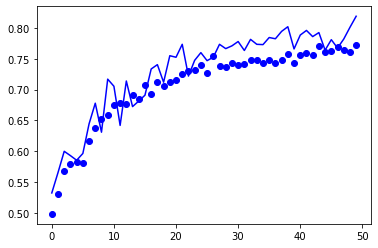

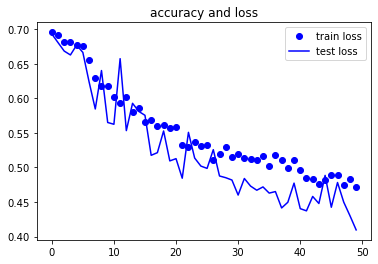

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, "bo", label='train accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')

plt.figure()
plt.plot(epochs, loss, "bo", label='train loss')
plt.plot(epochs, val_loss, 'b', label='test loss')

plt.title('accuracy and loss')
plt.legend()
plt.show()

In [12]:
model2 = tf.keras.models.Sequential([
    # 如果训练慢，可以数据设置的更小一些
    # 得到filter32个特征图，卷积核3*3，默认激活层直接加relu，input_data输入大小
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # 池化层一般都是2*2，基本不改
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    
    # 为全连接层做准备
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # 二分类digmoid就够了，输出0-1之间的概率值
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, "bo", label='train accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')

plt.figure()
plt.plot(epochs, loss, "bo", label='train loss')
plt.plot(epochs, val_loss, 'b', label='test loss')

plt.title('accuracy and loss')
plt.legend()
plt.show()

NameError: name 'history2' is not defined